<a href="https://colab.research.google.com/github/eshal26/Convolutional-Neural-Networks/blob/main/custom_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
import torch
import torch.nn as nn

class SimpleInceptionModel(nn.Module):
    def __init__(self):
        super(SimpleInceptionModel, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Convolution Layer 1
            nn.ReLU(),                                             # ReLU Activation
            nn.BatchNorm2d(16),                                  # Batch Normalization
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)    # Max Pooling
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Convolution Layer 2
            nn.ReLU(),                                              # ReLU Activation
            nn.BatchNorm2d(32),                                   # Batch Normalization
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)     # Max Pooling
        )

        # Dropout Layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

        # Flatten Layer
        self.flatten = nn.Flatten()  # Converts multi-dimensional tensors into a 1D vector


        self.fc1 = nn.Linear(32 * 56 * 56, 2)   # Linear layer for binary classification

        # Softmax for binary classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)      # Apply the first set of conv layers
        x = self.conv2(x)      # Apply the second set of conv layers
        x = self.flatten(x)    # Flatten the tensor
        x = self.dropout1(x)   # Apply the first dropout layer
        x = self.fc1(x)        # Apply the fully connected layer
        x = self.dropout2(x)   # Apply the second dropout layer
        x = self.softmax(x)   # Apply Softmax activation
        return x

model = SimpleInceptionModel()
print(model)

SimpleInceptionModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [47]:
from collections import Counter

# Extract labels from the train dataset
all_labels = [label for _, label in train_dataset]

# Convert to a numpy array
all_labels = np.array(all_labels)

# Print unique labels and counts
unique_labels, counts = np.unique(all_labels, return_counts=True)
print(f"Unique Labels: {unique_labels}")
print(f"Counts: {counts}")

# Calculate class weights
num_samples = len(all_labels)
num_classes = len(unique_labels)
class_counts = Counter(all_labels)
class_weights = {class_id: num_samples / (num_classes * count) for class_id, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float32)

print(f"Class Weights: {class_weights}")
print(f"Class Weights Tensor: {class_weights_tensor}")

Unique Labels: [0 1]
Counts: [ 352 1926]
Class Weights: {0: 3.2357954545454546, 1: 0.5913811007268951}
Class Weights Tensor: tensor([3.2358, 0.5914])


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [49]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    # Step the scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {epoch_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/20, Training Loss: 0.7419, Validation Loss: 0.4638, Validation Accuracy: 84.05%
Epoch 2/20, Training Loss: 0.5842, Validation Loss: 0.4864, Validation Accuracy: 82.00%
Epoch 3/20, Training Loss: 0.5584, Validation Loss: 0.4741, Validation Accuracy: 83.44%
Epoch 4/20, Training Loss: 0.5409, Validation Loss: 0.4634, Validation Accuracy: 84.66%
Epoch 5/20, Training Loss: 0.5363, Validation Loss: 0.4641, Validation Accuracy: 84.87%
Epoch 6/20, Training Loss: 0.5266, Validation Loss: 0.4342, Validation Accuracy: 87.73%
Epoch 7/20, Training Loss: 0.5229, Validation Loss: 0.4579, Validation Accuracy: 85.07%
Epoch 8/20, Training Loss: 0.5120, Validation Loss: 0.4298, Validation Accuracy: 88.34%
Epoch 9/20, Training Loss: 0.5142, Validation Loss: 0.4236, Validation Accuracy: 88.96%
Epoch 10/20, Training Loss: 0.5193, Validation Loss: 0.4380, Validation Accuracy: 87.32%
Epoch 11/20, Training Loss: 0.5122, Validation Loss: 0.4288, Validation Accuracy: 88.34%
Epoch 12/20, Training Loss: 0.

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.59      0.65        76
     Class 1       0.93      0.96      0.94       413

    accuracy                           0.90       489
   macro avg       0.83      0.78      0.80       489
weighted avg       0.90      0.90      0.90       489



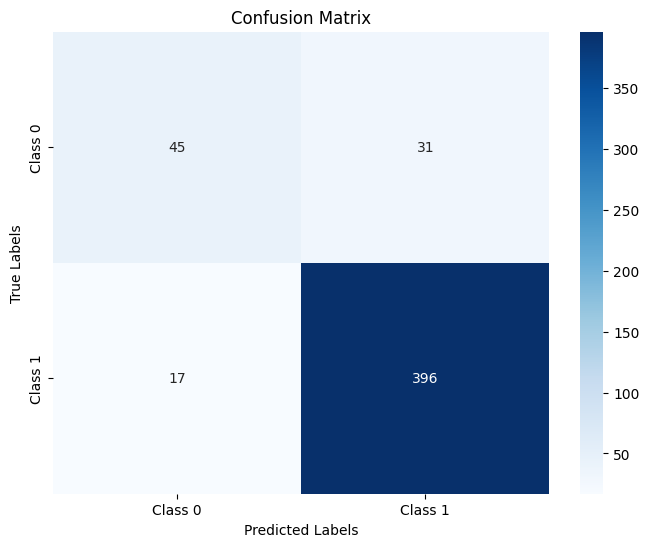

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Generate classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the test function
test_model(model, test_loader, device)


In [50]:
# Testing phase
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the GPU if available
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        test_loss += loss.item() * images.size(0)  # Accumulate loss

        _, predicted = torch.max(outputs, 1)  # Get the predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Compute average test loss and accuracy
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100 * correct / total

# Print test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.4150, Test Accuracy: 90.18%
